In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
basedir='/ocean/shared/SalishSeaCastData/DFO/CTD/'
dbname='DFO_CTD.sqlite'
datelims=(dt.datetime(2017,1,1),dt.datetime(2017,12,31))

In [3]:
df1=et.loadDFOCTD(basedir,dbname,datelims)

In [4]:
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,Fluor,dtUTC
0,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,1.1,28.322649,6.767869,1.186,2017-02-06 23:57:38
1,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,2.0,28.433543,6.910300,1.165,2017-02-06 23:57:38
2,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,2.8,28.587849,7.096281,1.137,2017-02-06 23:57:38
3,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,6.4,28.700628,7.205176,1.178,2017-02-06 23:57:38
4,2017.0,2.0,6.0,23.960556,48.658833,-123.499333,6.9,29.077813,7.656784,1.130,2017-02-06 23:57:38


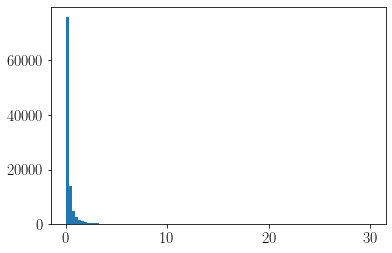

In [7]:
plt.hist(df1['Fluor'],100);

In [8]:
PATH= '/results2/SalishSea/nowcast-green.201905/'
year=2017

In [9]:
display(Markdown('''# Year: '''+ str(year)))

# Year: 2017

#### Define date range and load observations

In [10]:
start_date = datelims[0]
end_date = datelims[1]
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T',
         'ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}

In [11]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=True);

progress: 0.0%
progress: 3.546778461123761%
progress: 7.093556922247522%
progress: 10.640335383371283%
progress: 14.187113844495045%
progress: 17.733892305618806%
progress: 21.280670766742567%
progress: 24.82744922786633%
progress: 28.37422768899009%
progress: 31.92100615011385%
progress: 35.46778461123761%
progress: 39.014563072361376%
progress: 42.561341533485134%
progress: 46.1081199946089%
progress: 49.65489845573266%
progress: 53.20167691685642%
progress: 56.74845537798018%
progress: 60.29523383910394%
progress: 63.8420123002277%
progress: 67.38879076135147%
progress: 70.93556922247522%
progress: 74.48234768359899%
progress: 78.02912614472275%
progress: 81.5759046058465%
progress: 85.12268306697027%
progress: 88.66946152809403%
progress: 92.2162399892178%
progress: 95.76301845034155%
progress: 99.30979691146533%


In [12]:
# report coefficients used in 
try:
    nml=f90nml.read(os.path.join(PATH,'01jan'+str(year)[-2:],'namelist_smelt_cfg'))
    mod_chl_N=nml['nampisopt']['zzn2chl']
    print('Parameter values from 01jan'+str(year)[-2:]+' namelist_smelt_cfg:')
    print('   Chl:N = ',mod_chl_N)
    print('   zz_bfsi = ',nml['nampisrem']['zz_bfsi'])
    print('   zz_remin_d_bsi = ',nml['nampisrem']['zz_remin_d_bsi'])
    print('   zz_w_sink_d_bsi = ',nml['nampissink']['zz_w_sink_d_bsi'])
    print('   zz_alpha_b_si = ',nml['nampissink']['zz_alpha_b_si'])
    print('   zz_alpha_b_d = ',nml['nampissink']['zz_alpha_b_d'])
except:
    print('namelist_smelt_cfg not present in results file')

Parameter values from 01jan17 namelist_smelt_cfg:
   Chl:N =  2.0
   zz_bfsi =  6e-05
   zz_remin_d_bsi =  1.1e-06
   zz_w_sink_d_bsi =  0.00028
   zz_alpha_b_si =  0.92
   zz_alpha_b_d =  0.0


In [13]:
# chlorophyll calculations
data['l10_obsChl']=np.log10(data['Fluor']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Fluor']

In [15]:
# prep and load dictionary to save stats in
statsDict={year:dict()};

In [16]:
cm1=cmocean.cm.thermal
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [17]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
    ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
    ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y',),lname='SOG')
    ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m',),lname='NSOG')
    l=ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return (ps1,ps2,ps3,ps4),l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


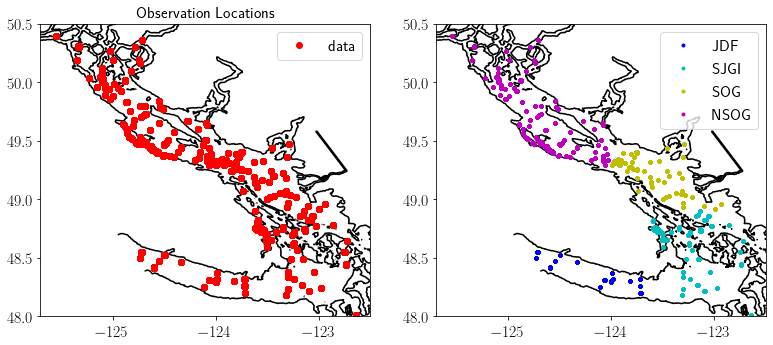

In [19]:
fig, ax = plt.subplots(1,2,figsize = (13,6))
viz_tools.set_aspect(ax[0], coords = 'map')
ax[0].plot(data['Lon'], data['Lat'], 'ro',label='data')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax[0], grid, coords = 'map',isobath=.1)
ax[0].set_ylim(48, 50.5)
ax[0].legend()
ax[0].set_xlim(-125.7, -122.5);
ax[0].set_title('Observation Locations');

viz_tools.set_aspect(ax[1], coords = 'map')
#ax[1].plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax[1].plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax[1].plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax[1].plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax[1].plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax[1], grid, coords = 'map')
ax[1].set_ylim(48, 50.5)
ax[1].legend()
ax[1].set_xlim(-125.7, -122.5);

# Also set up seasonal groupings:
iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [20]:
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND})

# Chlorophyll

In [22]:
obsvar='l10_obsChl'
modvar='l10_modChl'
statsDict[year]['Chl log10']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Chl log10'][isub]=dict()
    var=statsDict[year]['Chl log10'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
obsvar='Chl'
modvar='mod_Chl'
statsDict[year]['Chl']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Chl'][isub]=dict()
    var=statsDict[year]['Chl'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])

tempD={'Chl log10':statsDict[year]['Chl log10'],'Chl':statsDict[year]['Chl']}
tbl,tdf=et.displayStatsFlex(tempD,('Variable','Subset','Metric',''),
                        ['Order','Subset','Metric'],
                        ['Variable','Metric'],
                        suborder=list(statsubs.keys()))
tbl

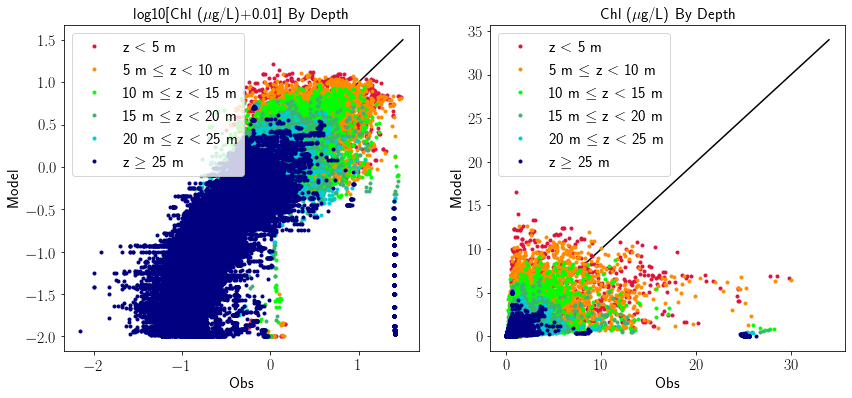

In [24]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01] By Depth')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chl','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L) By Depth');

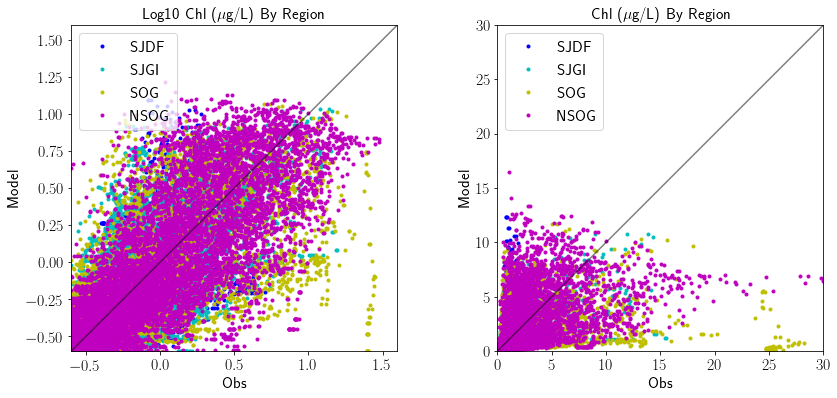

In [26]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
obsvar='l10_obsChl'; modvar='l10_modChl'
ps,l=byRegion(ax[0],obsvar,modvar,(-.6,1.6))
ax[0].set_title('Log10 Chl ($\mu$g/L) By Region');

obsvar='Chl'; modvar='mod_Chl'
ps,l=byRegion(ax[1],obsvar,modvar,(0,30))
ax[1].set_title('Chl ($\mu$g/L) By Region');

Text(0.5, 1.0, 'log Chl')

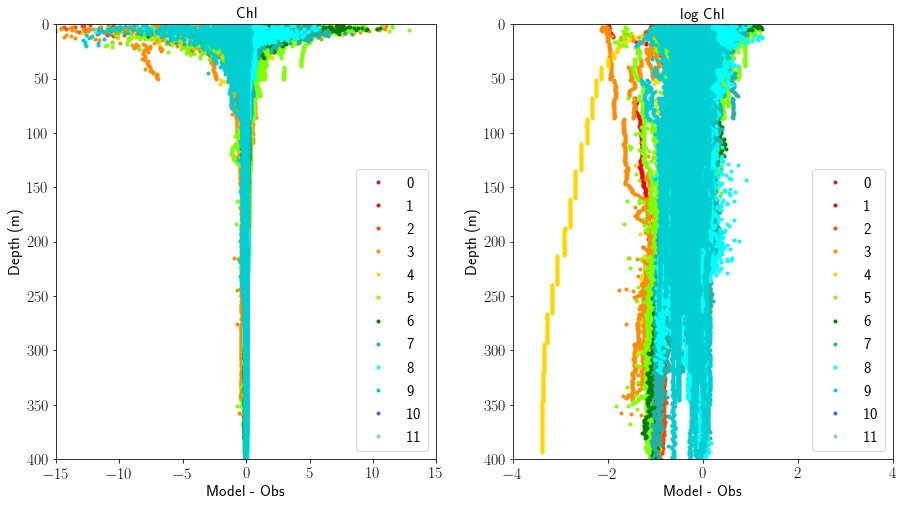

In [30]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_Chl']].values-data.loc[iii,['Chl']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['l10_modChl']].values-data.loc[iii,['l10_obsChl']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-4,4)
ax[0].set_title('Chl')
ax[1].set_title('log Chl')

## Conservative Temperature 

In [ ]:
obsvar='CT'
modvar='mod_votemper'
statsDict[year]['Temperature']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Temperature'][isub]=dict()
    var=statsDict[year]['Temperature'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Temperature'],level='Subset',suborder=list(statsubs.keys()))
tbl

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(5,20))
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(5,20))
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

In [ ]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

## Reference Salinity

In [ ]:
obsvar='SA'
modvar='mod_vosaline'
statsDict[year]['Salinity']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Salinity'][isub]=dict()
    var=statsDict[year]['Salinity'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Salinity'],level='Subset',suborder=list(statsubs.keys()))
tbl

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,36))
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,36))
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

In [ ]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,36))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Display All Stats

In [ ]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl